In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from tqdm import trange
import pickle

pd.set_option("display.max_columns", None)


In [70]:
us_users_txt = pd.read_csv("data/us_users_txt.csv")

In [71]:
us_users_txt.head()

,Unnamed: 0,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_id_ba,beer_name,brewery_id_ba,nbr_ratings_ba,style.1,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,nb_text_rev,language,polarity,subjectivity
0,7,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa,56,en,0.225843,0.588517
1,8,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa,56,en,-0.114394,0.483333
2,12,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa,56,en,0.084722,0.439074
3,14,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa,56,en,0.167949,0.565385
4,16,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,19827,Legbiter,10093,75,English Pale Ale,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa,56,en,0.398000,0.668333


In [72]:
print("Languages in the dataset are:", us_users_txt['language'].unique())

Languages in the dataset are: ['en' 'af' 'fr' 'tr' 'sw' 'es' 'UNKNOWN' 'ro' 'nl' 'de' 'no' 'da' 'ca'
 'tl' 'sv' 'fi' 'et' 'id' 'sk' 'lt' 'sq' 'so' 'it' 'hu' 'pl' 'hr' 'cy'
 'sl' 'pt' 'cs']


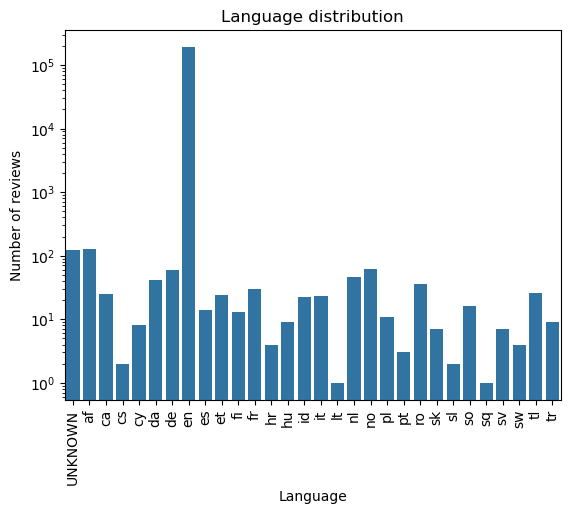

In [73]:
lang_dist = us_users_txt.groupby('language').count().reset_index()
sns.barplot(x='language', y='user_id', data=lang_dist)
plt.title('Language distribution')
plt.xlabel('Language')
plt.ylabel('Number of reviews')
plt.xticks(rotation=90)
plt.yscale('log')    

plt.show()

In [74]:
us_users_txt[us_users_txt["language"]=="cs"]

,Unnamed: 0,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_id_ba,beer_name,brewery_id_ba,nbr_ratings_ba,style.1,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,nb_text_rev,language,polarity,subjectivity
164510,853639,92095,Milk / Sweet Stout,1418986800,paulish,paulish.779746,4.0,4.0,4.00,4.25,4.00,4.10,16 oz. bottle. Nice milk stout.,False,5.5,3.981164,92095,Udderly Milk Stout,24134,275,Milk / Sweet Stout,3.636601,209262,12402,153,3.857991,"United States, South Carolina",Westbrook Brewing Co.,189,241,New York,4428.0,428,Cfa,32,cs,0.6,1.0
175621,898767,2557,Lambic - Fruit,1455620400,KensWorld,kensworld.887567,4.5,4.5,4.75,5.00,4.75,4.78,4oz pour,False,5.0,4.317438,2557,Cantillon Rosé De Gambrinus,388,2330,Lambic - Fruit,3.814407,6014,1069,1645,4.109265,Belgium,Brasserie Cantillon,82,77,Florida,1436.0,3975,Cfa,631,cs,0.0,0.0


In [75]:
us_users_txt[us_users_txt["language"]=="UNKNOWN"]

,Unnamed: 0,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_id_ba,beer_name,brewery_id_ba,nbr_ratings_ba,style.1,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,nb_text_rev,language,polarity,subjectivity
3024,48528,186934,Milk / Sweet Stout,1457866800,DucksFan16,ducksfan16.299717,4.25,4.00,4.00,4.00,4.00,4.02,03/12/2016,False,13.0,3.983333,186934,Spildt Mælk (Boys Don’t Cry Over Spilled Milk),24299,27,Milk / Sweet Stout,3.917778,344787,12119,45,3.942361,Denmark,To Øl,228,238,Alaska,2939.0,72,Dfc,11,UNKNOWN,0.0,0.0
3090,48854,176308,American Wild Ale,1462183200,DucksFan16,ducksfan16.299717,4.25,3.75,4.00,4.00,4.00,3.96,05/01/2016,False,5.5,4.137950,176308,Sur Citra,24299,161,American Wild Ale,3.706148,336876,12119,244,3.877802,Denmark,To Øl,228,238,Alaska,2939.0,405,Dfc,38,UNKNOWN,0.0,0.0
3422,50501,5654,American Adjunct Lager,1482490800,DucksFan16,ducksfan16.299717,3.50,3.00,3.50,3.25,3.25,3.23,12/22/2016,False,5.0,2.782651,5654,Hinano,2218,166,American Adjunct Lager,2.115209,7655,1284,526,2.275318,French Polynesia,Brasserie de Tahiti S.A.,5,5,Alaska,2939.0,692,Dfc,74,UNKNOWN,0.0,0.0
7087,62856,215147,Kellerbier / Zwickelbier,1461405600,pathman,pathman.600630,4.25,4.25,4.25,4.25,4.25,4.25,4/13/16,False,5.6,4.050714,215147,Weihenstephaner 1516 Kellerbier,252,392,Kellerbier / Zwickelbier,3.452881,399122,282,295,3.794003,Germany,Bayerische Staatsbrauerei Weihenstephan,24,30,Ohio,2766.0,687,Dfa,145,UNKNOWN,0.0,0.0
8539,66287,779,Doppelbock,1489834800,DucksFan16,ducksfan16.299717,4.00,4.00,4.25,4.25,4.25,4.18,03/17/2017,False,7.4,4.199002,779,Weihenstephaner Korbinian,252,2666,Doppelbock,3.777297,7823,282,1709,4.034272,Germany,Bayerische Staatsbrauerei Weihenstephan,24,30,Alaska,2939.0,4375,Dfc,1092,UNKNOWN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174971,895330,5281,Lambic - Fruit,1465984800,shmelvin,shmelvin.945021,5.00,5.00,5.00,5.00,5.00,5.00,5,False,5.0,4.650579,5281,Cantillon Fou' Foune,388,2903,Lambic - Fruit,4.057804,7502,1069,1102,4.487473,Belgium,Brasserie Cantillon,82,77,New York,81.0,4005,Cfa,465,UNKNOWN,0.0,0.0
175335,896816,5281,Lambic - Fruit,1487242800,Markyg21,markyg21.1000921,5.00,5.00,5.00,5.00,5.00,5.00,5,False,5.0,4.650579,5281,Cantillon Fou' Foune,388,2903,Lambic - Fruit,4.057804,7502,1069,1102,4.487473,Belgium,Brasserie Cantillon,82,77,Connecticut,144.0,4005,Dfb,465,UNKNOWN,0.0,0.0
175431,897443,53958,Lambic - Fruit,1475316000,DucksFan16,ducksfan16.299717,4.25,4.00,4.00,4.00,4.00,4.02,09/31/2016,False,5.0,4.214580,53958,Cantillon Mamouche,388,834,Lambic - Fruit,4.001911,128676,1069,628,4.123228,Belgium,Brasserie Cantillon,82,77,Alaska,2939.0,1462,Dfc,141,UNKNOWN,0.0,0.0
176434,901151,2558,Lambic - Fruit,1476007200,Ristaccia,ristaccia.704408,5.00,4.75,5.00,5.00,5.00,4.94,2010,False,5.0,4.414434,2558,Cantillon Vigneronne,388,1308,Lambic - Fruit,3.850000,6074,1069,956,4.176095,Belgium,Brasserie Cantillon,82,77,Nebraska,1684.0,2264,Dfa,270,UNKNOWN,0.0,0.0


In [76]:
us_users_txt[us_users_txt["language"]=="es"]

,Unnamed: 0,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_id_ba,beer_name,brewery_id_ba,nbr_ratings_ba,style.1,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,nb_text_rev,language,polarity,subjectivity
2971,48007,185885,American Wild Ale,1493287200,Facu,facu.1198525,3.00,4.00,4.50,4.00,4.00,3.99,Me gustó mucho. Una cerveza diferente. El arom...,True,9.00,3.897447,185885,Nelson Survin,24299,47,American Wild Ale,3.582143,344783,12119,140,3.661390,Denmark,To Øl,228,238,Rhode Island,2.0,187,Cfa,14,es,0.0,1.0
10532,72304,35625,Weizenbock,1434362400,nauxolo,nauxolo.398182,3.50,3.50,3.25,3.25,3.25,3.33,"Syrupy, tastes similar to delirium tremens",False,7.70,4.275830,35625,Weihenstephaner Vitus,252,3456,Weizenbock,3.777350,70791,282,1872,4.100689,Germany,Bayerische Staatsbrauerei Weihenstephan,24,30,California,18.0,5328,Csa,1017,es,0.0,0.4
28564,158138,22790,American IPA,1443088800,BEERMILER12,beermiler12.501917,4.25,4.25,4.50,4.25,4.50,4.33,On tap at Toronado San Francisco,False,6.10,4.362585,22790,Blind Pig IPA,863,5763,American IPA,3.997450,48429,1480,1412,4.290729,"United States, California",Russian River Brewing Company,108,105,Maine,1947.0,7175,Dfb,1367,es,0.0,0.0
29527,159409,22790,American IPA,1432202400,toronadotornado,toronadotornado.960426,4.50,4.50,4.75,4.75,4.50,4.63,"Toronado - San Francisco, CA - draft",False,6.10,4.362585,22790,Blind Pig IPA,863,5763,American IPA,3.997450,48429,1480,1412,4.290729,"United States, California",Russian River Brewing Company,108,105,California,331.0,7175,Csa,1367,es,0.0,0.0
30853,167059,12770,Belgian Strong Pale Ale,1443088800,BEERMILER12,beermiler12.501917,4.25,4.00,4.00,4.25,4.25,4.17,On tap at Toronado San Francisco,False,7.75,4.117370,12770,Damnation,863,3810,Belgian Strong Pale Ale,3.758171,13146,1480,1487,4.016534,"United States, California",Russian River Brewing Company,108,105,Maine,1947.0,5297,Dfb,1081,es,0.0,0.0
31678,168308,12770,Belgian Strong Pale Ale,1426676400,toronadotornado,toronadotornado.960426,4.50,4.25,4.50,4.50,4.50,4.44,"Toronado - San Francisco, CA",False,7.75,4.117370,12770,Damnation,863,3810,Belgian Strong Pale Ale,3.758171,13146,1480,1487,4.016534,"United States, California",Russian River Brewing Company,108,105,California,331.0,5297,Csa,1081,es,0.0,0.0
34469,184029,118094,Vienna Lager,1458990000,toronadotornado,toronadotornado.960426,3.75,3.75,4.00,4.00,3.75,3.88,"Biergarten - San Francisco, CA - draft",False,5.60,3.853913,118094,Westfalia,34017,46,Vienna Lager,3.356250,247915,18675,32,3.649744,"United States, California",Fort Point Beer Company,24,26,California,331.0,78,Csa,15,es,0.0,0.0
58838,317844,148,American Amber / Red Lager,1480676400,toronadotornado,toronadotornado.960426,3.50,3.25,3.75,3.75,3.75,3.62,"JetBlue - Las Vegas, NV - can",False,5.20,3.723494,148,Brooklyn Lager,45,3643,American Amber / Red Lager,3.448055,528,90,2493,3.611586,"United States, New York",Brooklyn Brewery,181,179,California,331.0,6136,Csa,1039,es,0.0,0.0
97521,473316,22344,English Porter,1482145200,Malacant,malacant.1021155,4.00,4.25,4.25,4.00,4.00,4.09,Delicious porter.,False,6.00,3.791915,22344,Gulf Porter,10990,47,English Porter,3.338182,49381,5747,55,3.547255,"United States, Mississippi",Lazy Magnolia Brewing Company,48,47,Louisiana,125.0,102,Cfa,20,es,1.0,1.0
109290,540570,89747,American IPA,1477216800,pathman,pathman.600630,4.75,4.75,4.75,4.75,4.75,4.75,10/23/2016 can,False,7.30,4.081730,89747,Overrated West Coast IPA,13014,1659,American IPA,3.738771,208164,6337,472,4.005767,"United States, Minnesota",Surly Brewing Company,166,161,Ohio,2766.0,2131,Dfa,235,es,0.0,0.0


In [77]:
micro_average_polarity = us_users_txt["polarity"].mean()

display(micro_average_polarity)

climate_average_polarity = us_users_txt.groupby("climate")["polarity"].mean()
display(climate_average_polarity)
macro_average_polarity = climate_average_polarity.mean()

display(macro_average_polarity)


0.1859383474788234

climate
Bsk    0.192822
Cfa    0.185747
Cfb    0.192785
Csa    0.186389
Csb    0.187885
Dfa    0.185133
Dfb    0.186279
Dfc    0.188569
Dsb    0.183177
Dsc    0.180428
Name: polarity, dtype: float64

0.18692136901744102

Text(0.5, 1.0, 'Polarity by climate')

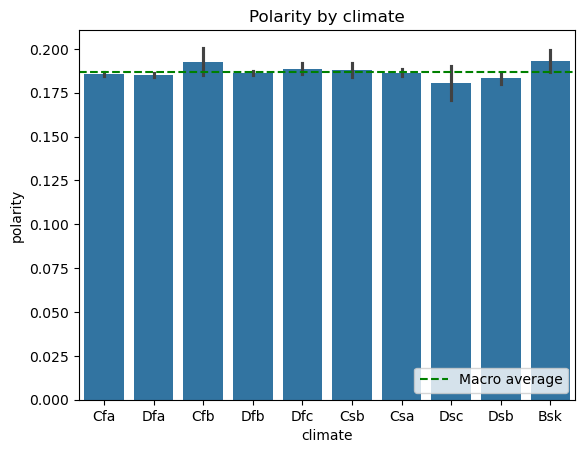

In [78]:
sns.barplot(x='climate', y='polarity', data=us_users_txt)
#plot dashed green line at macro average
plt.axhline(macro_average_polarity, color='g', linestyle='--', label='Macro average')
plt.legend( loc = 'lower right')
plt.title('Polarity by climate')

In [82]:
climates = us_users_txt["climate"].unique()
print(climates)

# load nlp model from spacy
nlp = spacy.load("en_core_web_sm")

adj_climate = [[]]*len(climates)
for i in trange(len(climates)):
    txt = us_users_txt[us_users_txt["climate"]==climates[i]]
    for j in range(len(txt)):
        doc = nlp(txt["text"].iloc[j])
        adj_climate[i]= adj_climate[i] + [token.text for token in doc if token.pos_ == "ADJ"]
#save adj_climate as a csv
with open('adj_climate.pkl', 'wb') as fp:
    pickle.dump(adj_climate, fp)
     


['Cfa' 'Dfa' 'Cfb' 'Dfb' 'Dfc' 'Csb' 'Csa' 'Dsc' 'Dsb' 'Bsk']


100%|██████████| 10/10 [1:55:35<00:00, 693.57s/it]  


In [83]:
with open('adj_climate.pkl', 'wb') as fp:
    pickle.dump(adj_climate, fp)

[['Light', 'opaque', 'brown', 'weird', 'more', 'sure', 'derivative', 'earthy', 'noble', 'dark', 'dark', 'nutty', 'excessive', 'normal', 'ok', 'right'], ['hazy', 'strong', 'fair', 'sticky', 'spicy', 'hoppy', 'sweet', 'light', 'bitter', 'light', 'bodied', 'low', 'acrid', 'much', 'pleasant'], ['deep', 'impressive', 'thick', 'pleasing', 'light', 'full', 'smooth', 'full', 'sweet', 'lighty', 'slight', 'strong', 'few', 'best', 'good'], ['solid'], ['3rd', 'clear', 'best', 'clear', 'close', 'light', 'lightest', 'nice', 'whole', 'nice', 'good', 'back', 'goodly', 'grassy', 'sweet', 'earthy', 'different', 'Curious', 'least', 'lightish', 'more', 'glad'], ['great', 'clear', '1&quot', 'tiny', 'nice', 'nice', 'good', 'Simple', 'inviting', 'Big', 'light', 'nice', 'high', 'similar', 'good', 'mid', 'big', 'true', 'sure', 'quaffable', 'only', 'bitter', 'happy', 'grand', 'decent', 'more'], ['back', 'hazy', 'great', 'imperial', 'complex', 'mild', 'nondescript', 'inviting', 'Big', 'nice', 'possible', 'nice',